In [1]:
import torch

from model.swan import SWANPhase1Only
from test_model import load_config
from common.dataset import Dataset
from learner import *
from visualization.visualizer import *

In [2]:
# 'Sears tower' problem
SPLIT = 'dev'
PROBLEM_IDX = 49
BATCH_SIZE = 1

In [3]:
chpt_path = set_ckpt_path('best_SWAN_P1', from_pretrained=True)

# load pretrained
tokenizer = torch.load(chpt_path / 'tokenizer.pt') 
checkpoint = torch.load(chpt_path / 'SWANPhase1Only.pt')
config = load_config(chpt_path)

# set seed
set_seed(config['seed'])

# create model instance
nvix = SWANPhase1Only.create_or_load(path=str(chpt_path), **config)
nvix.explanation_pghead.debug = True
nvix.eval()

# load dataset
dataset_path = set_ckpt_path('dataset', from_pretrained=False)
test_data = Dataset(dataset_path / 'pen.json', number_window=3, include_skip=True)
#load experiment files
experiment_path = set_ckpt_path('experiments', from_pretrained=False)
test_data.select_items_with_file(experiment_path / 'pen' / SPLIT)

# load (single) batch
batch = test_data.get_minibatches(batch_size=BATCH_SIZE, for_testing= True)

# get outputs from model
output = nvix(
    text=batch[PROBLEM_IDX].text.to(nvix.device),
    beam=3,
    beam_expl=1
)

[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/electra-base-discriminator were

In [4]:
explanations = output['explanation'][0].to_human_readable(tokenizer=tokenizer, include_skip=True)

In [6]:
output

{'eqn_ignore': {1},
 'var_expl': [Label([[102, 1996, 15796, 3091, 1997, 1996, 2198, 1011, 4094, 2415, 1999, 3190, 3578, 102]])],
 'num_expl': [Label([[102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 13558, 102, -1, -1, -1, -1, -1], [102, 1996, 3091, 1997, 1996, 18493, 3578, 102]])],
 'explanation': [Explanation(numbers=$[Label([[102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 13558, 102, -1, -1, -1, -1, -1], [102, 1996, 3091, 1997, 1996, 18493, 3578, 102]])], variables=$[Label([[102, 1996, 15796, 3091, 1997, 1996, 2198, 1011, 4094, 2415, 1999, 3190, 3578, 102]])], worker=$0)],
 'equation': Equation(operator=Label([[0]]), operands=[Label([[-1]]), Label([[-1]])])}

In [4]:
tokenizer.encode('the height of the sears tower')

[101, 1996, 4578, 1997, 1996, 18493, 3578, 102]

OrderedDict([('X_00', ['the', 'approximate', 'length', 'of', 'the', 'john', '-', 'scale', 'center', 'in', 'chicago', 'tower']), ('N_00', ['the', 'height', 'of', 'the', 'sears', 'tower']), ('N_01', ['the', 'height', 'of', 'the', 'sears', 'tower']), ('N_02', ['skip']), ('N_03', ['the', 'length', 'of', 'the', 'sears', 'tower'])])


/home/cocochanel/NVIX/visualization/visualizer.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['']+['<BOS>']+[t for t in sentence]+['<EOS>'],
/home/cocochanel/NVIX/visualization/visualizer.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+expl_list)
/home/cocochanel/NVIX/visualization/visualizer.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['']+expl_list)


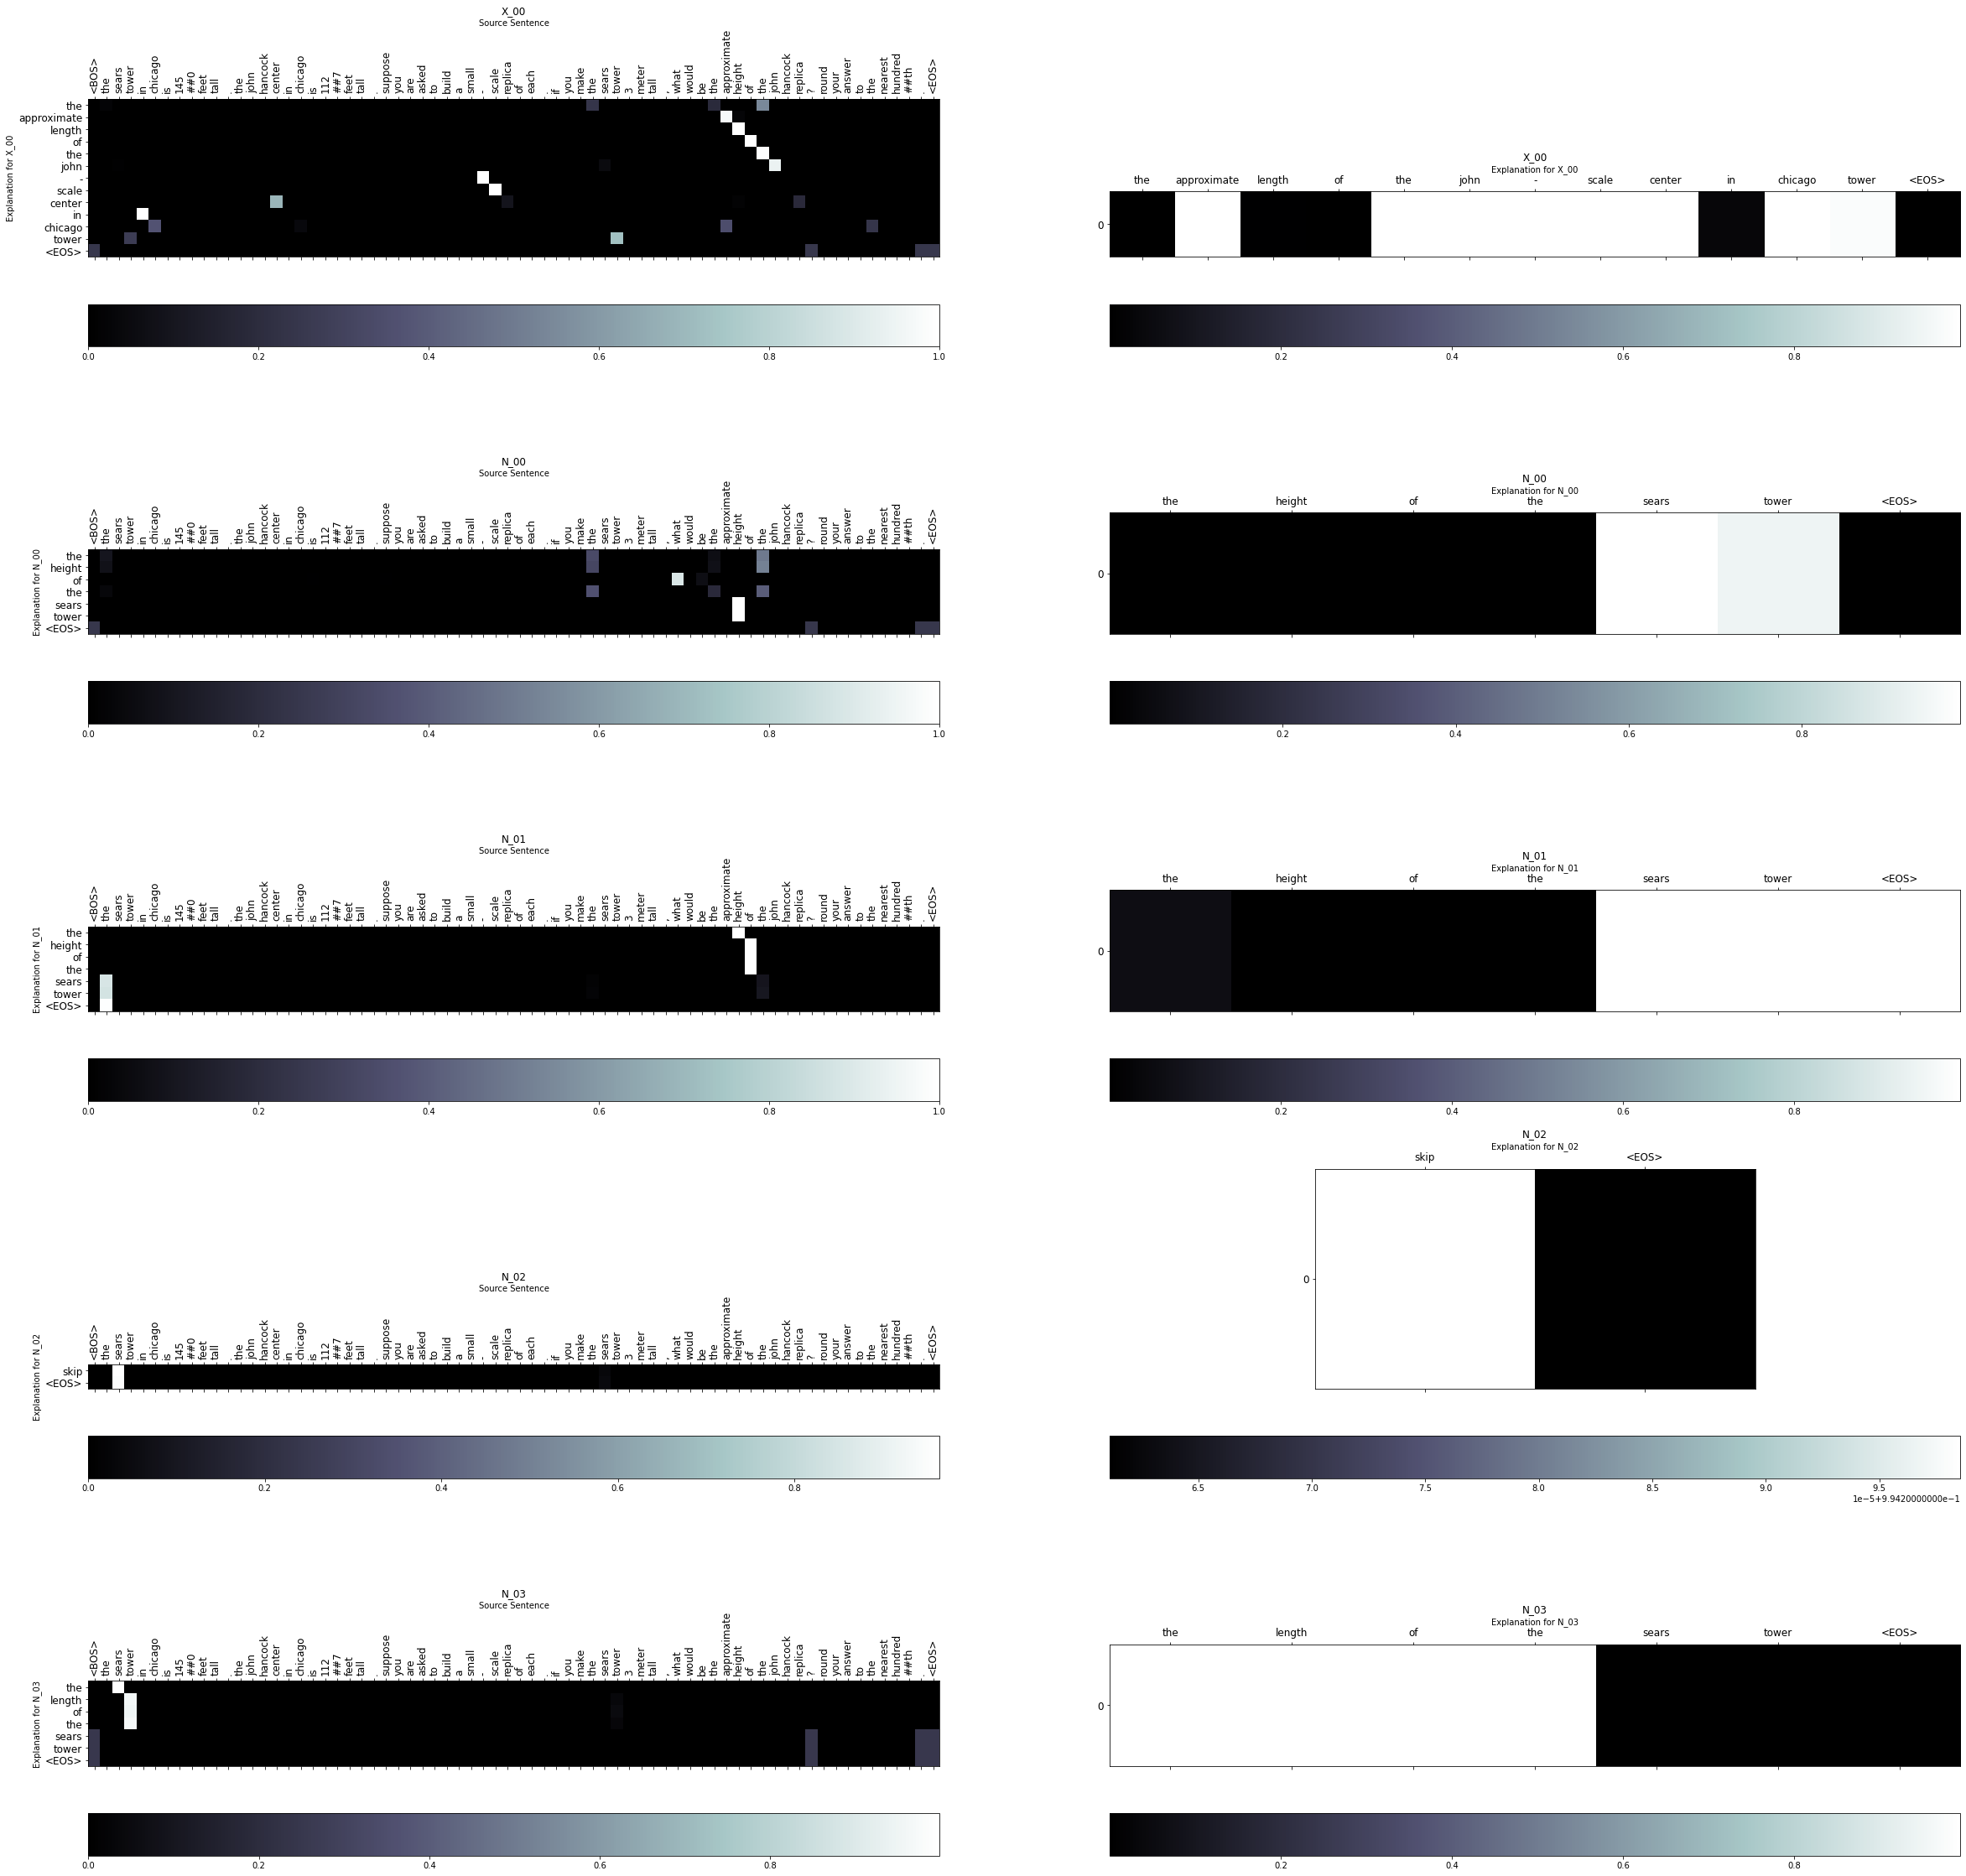

In [10]:
display_heatmap(
    sentence=batch[PROBLEM_IDX].text.raw[0].split(),
    explanation=explanations,
    attention=nvix.inter_values(type='attn_score', is_log=True),
    copy_probs=nvix.inter_values(type='copy_prob', is_log=True),
    figure_name='output_test'
)

In [12]:
batch[PROBLEM_IDX].explanation[0].to_human_readable(tokenizer=tokenizer, include_skip=True)

defaultdict(list,
            {'N_00': ['how tall sears tower is',
              'the height of the sears tower',
              'the height of the sears tower in chicago'],
             'N_01': ['how tall hancock center is',
              'the height of the john hancock center',
              'the height of the john hancock center in chicago'],
             'N_02': ['skip', 'skip', 'skip'],
             'N_03': ['height of the sears tower replica',
              'the height of the sears tower replica',
              'the height of the sears tower as a small - scale replica'],
             'X_00': ['the height of hancock replica',
              'the height of the john hancock replica',
              'the height of the john hancock tower as a small - scale replica']})

In [16]:
output

{'eqn_ignore': {1},
 'var_expl': [Label([[102, 1996, 15796, 3091, 1997, 1996, 2198, 1011, 4094, 2415, 1999, 3190, 3578, 102]])],
 'num_expl': [Label([[102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 13558, 102, -1, -1, -1, -1, -1], [102, 1996, 3091, 1997, 1996, 18493, 3578, 102]])],
 'explanation': [Explanation(numbers=$[Label([[102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 1996, 4578, 1997, 1996, 18493, 3578, 102], [102, 13558, 102, -1, -1, -1, -1, -1], [102, 1996, 3091, 1997, 1996, 18493, 3578, 102]])], variables=$[Label([[102, 1996, 15796, 3091, 1997, 1996, 2198, 1011, 4094, 2415, 1999, 3190, 3578, 102]])], worker=$0)],
 'equation': Equation(operator=Label([[0]]), operands=[Label([[-1]]), Label([[-1]])])}

In [6]:
output['explanation'][0].to_human_readable(tokenizer=tokenizer)

defaultdict(list,
            {'N_00': ['the height of the sears tower'],
             'N_01': ['the height of the sears tower'],
             'N_03': ['the length of the sears tower'],
             'X_00': ['the approximate length of the john - scale center in chicago tower']})

In [8]:
state_dict = nvix.state_dict()

In [13]:
expl_states = [k for k in state_dict if 'explanation' in k]

In [21]:
for s in state_dict:
    if 'explanation' in s: 
        print(f"{s}'s size: {state_dict[s].shape}")

explanation._prefix_number's size: torch.Size([3])
explanation.embeddings.position_ids's size: torch.Size([1, 512])
explanation.embeddings.word_embeddings.weight's size: torch.Size([30522, 768])
explanation.embeddings.position_embeddings.weight's size: torch.Size([512, 768])
explanation.embeddings.token_type_embeddings.weight's size: torch.Size([2, 768])
explanation.embeddings.LayerNorm.weight's size: torch.Size([768])
explanation.embeddings.LayerNorm.bias's size: torch.Size([768])
explanation.encoder.layer.0.attention.self.query.weight's size: torch.Size([768, 768])
explanation.encoder.layer.0.attention.self.query.bias's size: torch.Size([768])
explanation.encoder.layer.0.attention.self.key.weight's size: torch.Size([768, 768])
explanation.encoder.layer.0.attention.self.key.bias's size: torch.Size([768])
explanation.encoder.layer.0.attention.self.value.weight's size: torch.Size([768, 768])
explanation.encoder.layer.0.attention.self.value.bias's size: torch.Size([768])
explanation.enco